In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import Configuration
from importlib import reload
reload(Configuration)
from Configuration import ITERATIONS, AUCTIONS, N_USERS, N_ADVERTISERS, NUMBER_OF_PRICES, MIN_PRICE, MAX_PRICE, PRICES, COST, BUDGET, BUDGET_PER_DAY, NUMBER_OF_SLOTS, LAMBDAS, DAYS

## PRICING

In [3]:
def changing_x(t):
    tau = 50.0
    """# we change value of x every tau time steps"""
    t = t / tau
    t -= np.pi # just to make it start at 0
    x = np.sin(t)# we will consider a noise in the third part of the project, the extension of pricing + np.random.normal(0,0.5)
    return (x+1)/4 # bounded between 0 and 0.5

conversion_probability = lambda p,t: 1 - np.exp(p/MAX_PRICE - 1)/2 - changing_x(t)  # expected demand curve in terms of probability of purchase

In [4]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost
        

    def round(self, p_t, n_t, t): #n_t is the numebr of customers at time t, p_t is the price at time t
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t, t)) #demand at time t
        r_t = (p_t - self.cost)*d_t #reward at time t
        return d_t, r_t    

In [5]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

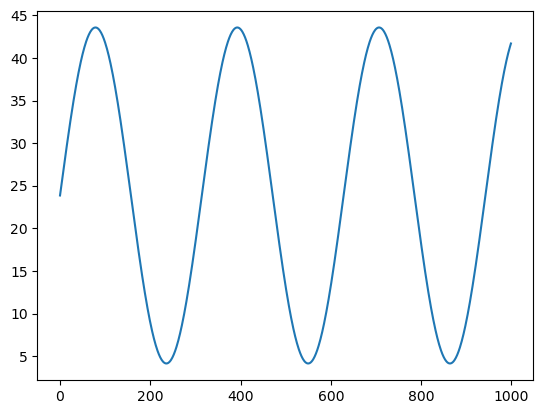

In [6]:
T = DAYS
t_interval = range(T)

prices = PRICES
cost = COST

n_customers = N_USERS # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: (price-cost)*n_sales  # profit curve
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
# at first let's compute an array of profit curves for each time
profit_curve = lambda t: reward_function(prices, n_customers*conversion_probability(prices, t))
# the baseline for an adversarial MAB is the reward obtained by the best FIXED action
rewards = np.array([profit_curve(t) for t in t_interval])
total_rewards = np.sum(rewards, axis=0)
best_price_index = np.argmax(total_rewards)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = rewards[:, best_price_index]

plt.figure()
plt.plot(t_interval, expected_clairvoyant_rewards, label='Expected Clairvoyant Reward')

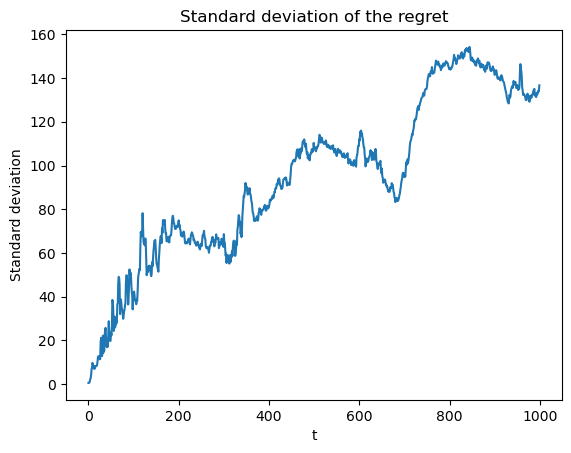

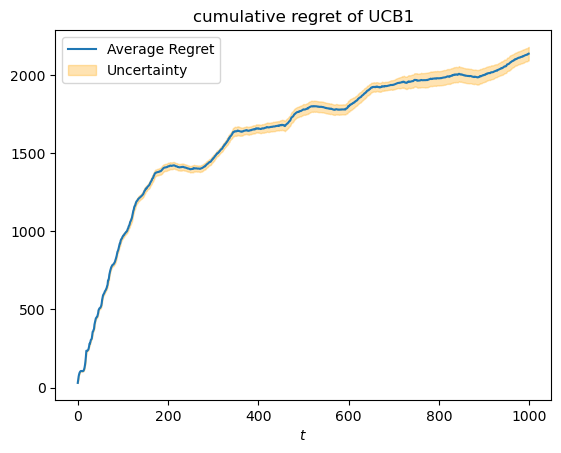

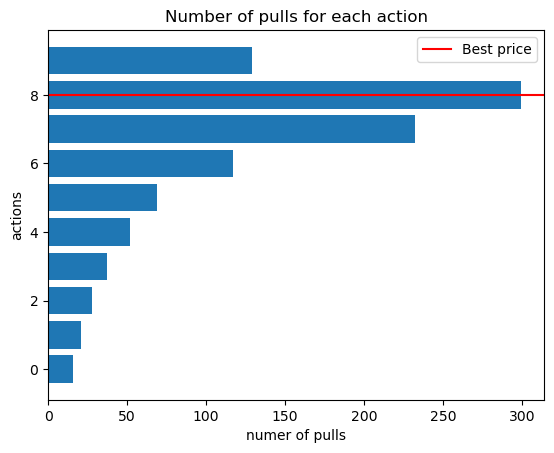

In [7]:

n_trials = 10#ITERATIONS

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent(NUMBER_OF_PRICES, T, range=maximum_profit/2) # modified parameter to decrease exporation improving the performance

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers, t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)
plt.plot(regret_sd)
plt.title('Standard deviation of the regret')
plt.xlabel('t')
plt.ylabel('Standard deviation')
plt.show()

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty', color='orange')

plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(NUMBER_OF_PRICES), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()

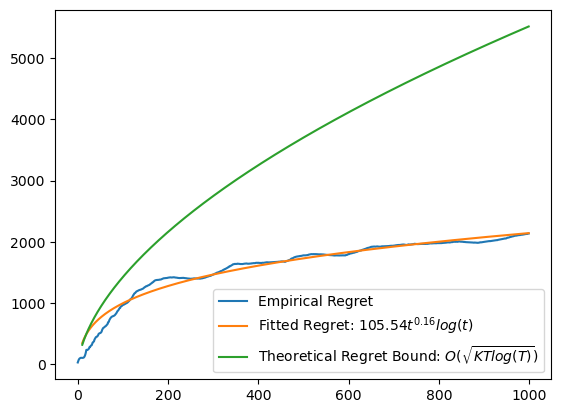

In [8]:
from scipy.optimize import curve_fit
fit_window = np.arange(10, T)
def model(x, a, b):
    return a*(x**b*(np.log(x)))

popt, pcov = curve_fit(model, fit_window, average_regret[fit_window])
ymodel = model(fit_window, *popt)

fig, ax = plt.subplots()
ax.plot(np.arange(T), average_regret, label='Empirical Regret')
ax.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
max_regret_theoretical = lambda t: 21*(NUMBER_OF_PRICES*t*np.log(t))**0.5
ax.plot(fit_window, max_regret_theoretical(fit_window), label='Theoretical Regret Bound: $O(\sqrt{KTlog(T)})$')
ax.legend()

## AUCTIONS

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

In [10]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [11]:
##### NEW CLASS TO HAVE MULTIPLE SLOTS
class FirstPriceAuction(Auction):
    def __init__(self, ctrs, lambdas):
        self.ctrs = ctrs
        self.lambdas = lambdas
        self.n_adv = len(self.ctrs)
        self.n_slots = len(self.lambdas)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values) 
        winners = np.flip(adv_ranking[-self.n_slots:]) # important to flip the order from higher to lower
        winners_values = adv_values[winners]
        return winners, winners_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

Pattern definition

sorted from largest to smallest;  True


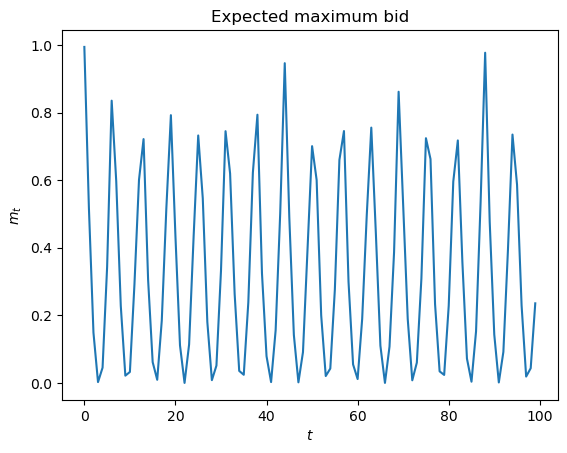

In [12]:
### Adversarial Bidders
#### interest !!
my_valuation = 1 # valuation will be scaled by the won slot prominence
rho = BUDGET/N_USERS

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(50*t/N_USERS))
other_bids = np.array([np.random.uniform(0, pattern(t), size = N_ADVERTISERS) for t in range(N_USERS)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)
other_bids_sorted = np.flip(np.sort(other_bids, axis=0), axis=0)
print("sorted from largest to smallest; ", np.all(other_bids_sorted[0, :] == m_t))

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()


In [13]:

# multiple slots
def get_slot_won(bid, sorted_bids, n_slots):
    """Returns the slot won by the bid at a specific time-step"""
    for s in range(n_slots):
        if bid > sorted_bids[s]:
            return s
    return None
def get_bid_win_probabilities(bid, sorted_bids, lambdas):
    n_user = sorted_bids.shape[1]
    probabilities = np.zeros(len(lambdas))
    for u in range(n_user):
        slot = get_slot_won(bid, sorted_bids[:, u], len(lambdas))
        if slot is not None:
            probabilities[slot] += 1

    return probabilities/n_user

win_probabilities_multiple_slots = np.array([get_bid_win_probabilities(b, other_bids_sorted, LAMBDAS) for b in PRICES])

c = np.zeros(len(PRICES))
for i, b in enumerate(PRICES):
    c[i] = -np.sum((my_valuation*LAMBDAS - b)*win_probabilities_multiple_slots[i, :])
    
A_ub = [PRICES*np.sum(win_probabilities_multiple_slots, axis=1)]
A_eq = [np.ones(len(PRICES))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=[rho], A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities_multiple_slots = [-res.fun for u in range(N_USERS)]
expected_clairvoyant_bids_multiple_slots = [sum(PRICES*gamma*np.sum(win_probabilities_multiple_slots, axis=1)) for u in range(N_USERS)]

In [14]:
class HedgeAgent:
    def __init__(self, narms, learning_rate): #ho tolto il numero di slot da questa classe per tenere solo narms
        self.narms = narms   #number of possible bids
        self.learning_rate = learning_rate #supposing it's the rate at which the algorithm progress
        self.weights = np.ones(narms) #weight == proportionnal to the probabilty
        self.x_t = np.ones(narms)/narms #probability of a bid to be played
        self.a_t = None # bid choice done during the round
        self.t = 0

    def pull_arm(self): #choose which arm to play
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.narms), p=self.x_t)
        return self.a_t

    def update(self, l_t): #update the weights
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [15]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta, lambdas):
        self.bids_set = bids_set #available choices
        self.K = len(bids_set) # number of possible bids
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation #what you earn, ctr*profit_per_click
        self.budget = budget
        self.eta = eta #learning rate for the pacing, i.e. how much we update the pacing multiplier
        self.T = T  #number of rounds
        self.rho = self.budget/self.T #bid limit
        self.lmbd = 1 #pacing multiplier, when we spend more than rho it increses otherwise we decrease it
        self.t = 0
        self.lambdas = lambdas

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, sorted_bids):
        # update hedge
        f_t_full = np.zeros(self.K)
        c_t_full = np.zeros(self.K)
        for i, b in enumerate(self.bids_set): # full (expert) feedback
            if (get_slot_won(b, sorted_bids, len(self.lambdas)) is not None):
                f_t_full[i] = self.valuation*self.lambdas[get_slot_won(b, sorted_bids, len(self.lambdas))] - b
                c_t_full[i] = b
                
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

## Trial

First iteration

In [16]:
### SAME OF BEFORE, THIS IS THE NEW BLOCK FOR MULTIPLE SLOTS
all_regrets = []
all_payments = []

eta = 1/np.sqrt(N_USERS)  # Learning rate from theory
q_a = np.random.rand(N_ADVERTISERS+1, NUMBER_OF_SLOTS)  # 11 rows (10 advertisers + me), 3 coloumns
ctrs = LAMBDAS*q_a
avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners


for i in range(ITERATIONS):
    agent = FFMultiplicativePacingAgent(bids_set = PRICES,
                                        valuation=my_valuation,
                                        budget=BUDGET,
                                        T=N_USERS,
                                        eta=eta,
                                        lambdas=LAMBDAS)

    auction = FirstPriceAuction(avg_ctrs, lambdas=LAMBDAS)  # Auction setup
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    total_wins = 0

    np.random.seed(i)
    for u in range(N_USERS):
        my_win = 0
        rank = 0
        # Agent places a bid
        my_bid = agent.bid()

        # Gather all bids for this auction
        bids = np.append(my_bid, other_bids[:, u].ravel())

        # Determine winners and payments
        winners, payments_per_click = auction.get_winners(bids=bids)

        # Check if the agent won
        #WE ADDED THIS FOR CICLE TO CHECK IF I WON AT LEAST ONE SLOT
        my_win = 0
        for i in range(len(winners)):
            if winners[i]==0:
                my_win = 1
                rank = i # THIS IS TO CHEK LATER THE UTILITY CONSIDERING THE VALUATION OF THE SLOT I WON
                break

        # Calculate the utility and payment for the agent
        f_t = (my_valuation*LAMBDAS[rank] - my_bid) if my_win else 0
        c_t = my_bid*my_win

        # Update the agent's learning based on the auction outcome
        agent.update(f_t, c_t, other_bids_sorted[:, u])

        # Store the results
        utilities = np.append(utilities, f_t)  # Append utility
        my_bids = np.append(my_bids, my_bid)  # Append bid
        my_payments = np.append(my_payments, c_t)  # Append payment
        total_wins += my_win  # Increment total wins

        cumulative_payments = np.cumsum(my_payments)


    all_regrets.append(np.cumsum(expected_clairvoyant_utilities_multiple_slots-utilities))
    all_payments.append(cumulative_payments)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

graphical representation

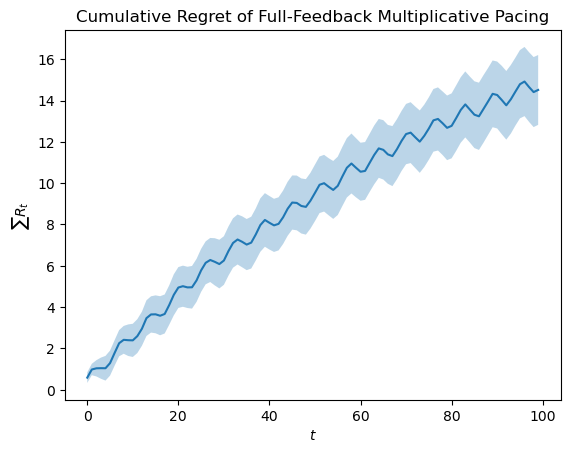

In [17]:
plt.plot(np.arange(N_USERS), avg_regret)
plt.fill_between(np.arange(N_USERS), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

Fitted exponent: 0.4475640423145834


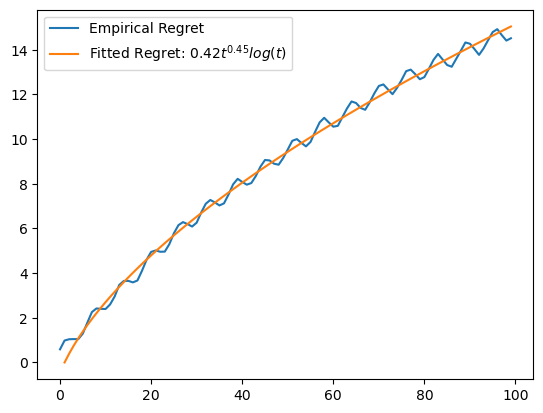

In [18]:
from scipy.optimize import curve_fit
fit_window = np.arange(1, N_USERS)
def model(x, a, b):
    return a*(x**b*(np.log(x)))

popt, pcov = curve_fit(model, fit_window, avg_regret[fit_window])
ymodel = model(fit_window, *popt)
print('Fitted exponent:', popt[1])

fig, ax = plt.subplots()
ax.plot(np.arange(N_USERS), avg_regret, label='Empirical Regret')
ax.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
ax.legend()

## MIX

#### now we have $d$ days and $a$ auctions in each day; the pricing algorithm makes a step once a day, the bidding algorithm once per auction

In [19]:
days = DAYS
auctions_per_day = AUCTIONS
budget = BUDGET_PER_DAY * days

In [20]:
d_interval = range(days)

prices = PRICES
cost = COST

max_customers = auctions_per_day # The maximum number of customers depends on how many times an ads is shown

reward_function = lambda price, n_sales: (price-cost)*n_sales  # profit curve
maximum_profit = reward_function(max(prices), max_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
# at first let's compute an array of profit curves for each day
profit_curve = lambda d: reward_function(prices, max_customers*conversion_probability(prices, d))
# the baseline for an adversarial MAB is the reward obtained by the best FIXED action
rewards = np.array([profit_curve(d) for d in d_interval])
total_rewards = np.sum(rewards, axis=0)
best_price_index = np.argmax(total_rewards)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = rewards[:, best_price_index]

sorted from largest to smallest;  True


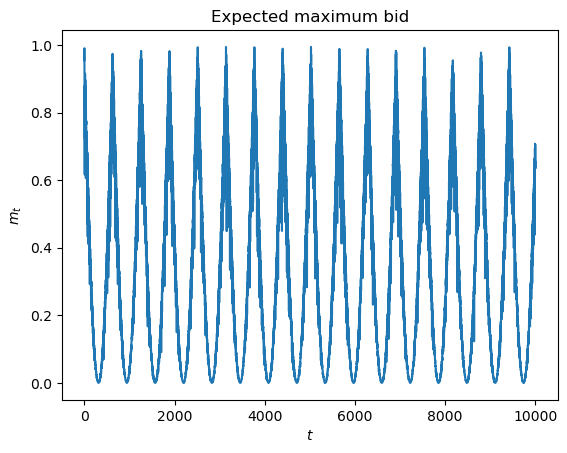

In [21]:
### Adversarial Bidders
#### interest !!
my_valuation = 1 # valuation will be scaled by the won slot prominence
total_auctions = days*auctions_per_day
rho = budget/total_auctions

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(50*t/total_auctions))
other_bids = np.array([np.random.uniform(0, pattern(t), size = N_ADVERTISERS) for t in range(total_auctions)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)
other_bids_sorted = np.flip(np.sort(other_bids, axis=0), axis=0)
print("sorted from largest to smallest; ", np.all(other_bids_sorted[0, :] == m_t))

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()


In [22]:
# multiple slots
def get_slot_won(bid, sorted_bids, n_slots):
    """Returns the slot won by the bid at a specific time-step"""
    for s in range(n_slots):
        if bid > sorted_bids[s]:
            return s
    return None
def get_bid_win_probabilities(bid, sorted_bids, lambdas):
    n_user = sorted_bids.shape[1]
    probabilities = np.zeros(len(lambdas))
    for u in range(n_user):
        slot = get_slot_won(bid, sorted_bids[:, u], len(lambdas))
        if slot is not None:
            probabilities[slot] += 1

    return probabilities/n_user

win_probabilities_multiple_slots = np.array([get_bid_win_probabilities(b, other_bids_sorted, LAMBDAS) for b in PRICES])

# multiple slots
c = np.zeros(len(PRICES))
for i, b in enumerate(PRICES):
    c[i] = -np.sum((my_valuation*LAMBDAS - b)*win_probabilities_multiple_slots[i, :])
    
A_ub = [PRICES*np.sum(win_probabilities_multiple_slots, axis=1)]
A_eq = [np.ones(len(PRICES))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=[rho], A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities_multiple_slots = [-res.fun for a in range(total_auctions)]
expected_clairvoyant_bids_multiple_slots = [sum(PRICES*gamma*np.sum(win_probabilities_multiple_slots, axis=1)) for a in range(total_auctions)]

In [23]:
def simulation_report(func):
  #@wraps(func)
  def wrapper(*args, **kwargs):
    begin = time.time()
    my_payments, my_bids, utilities, my_prices, total_wins_per_trial, pricing_regret_per_trial, tmp_pricing_rewards, bidding_regret_per_trial = func(*args, **kwargs)
    end = time.time()
    print('------------------------- PARAMS -------------------------')
    print(f'- n_trials: {kwargs.get("n_trials")}')
    print(f'- n_days: {kwargs.get("iterations")}')
    print(f'- n_auctions per day: {kwargs.get("auctions")}')
    print(f'- n_advertisers: {kwargs.get("n_advertisers")}')
    print(f'- my valuation: {kwargs.get("my_valuation")}')
    print(f'- production cost: {kwargs.get("cost")}')
    print(f'- budget: {kwargs.get("budget")}')
    print('------------------------- RESULTS -------------------------')
    print(f'Total time taken in {func.__name__} is {round(end - begin,2)} seconds')
    print(f'Percentage of auctions won: {(total_wins_per_trial.mean()*100)/(kwargs.get("iterations")*kwargs.get("auctions"))}')
    print('----------------------------------------------------')

    # let's plot some data
    fig, axs = plt.subplots(nrows=2,ncols=4, figsize=(22,10))
    axs = axs.flatten()

    # plotting the payments
    average_my_payments = np.mean(my_payments, axis=0)
    sd_my_payments = np.std(my_payments, axis=0)
    axs[0].plot(average_my_payments)
    axs[0].fill_between(range(kwargs.get('iterations')*kwargs.get('auctions')), average_my_payments-sd_my_payments, average_my_payments+sd_my_payments, alpha=0.3)
    axs[0].set_title('Average payments')

    # plotting the bids
    average_my_bids = np.mean(my_bids, axis=0)
    sd_my_bids = np.std(my_bids, axis=0)
    axs[1].plot(average_my_bids)
    axs[1].fill_between(range(len(average_my_bids)), average_my_bids-sd_my_bids, average_my_bids+sd_my_bids, alpha=0.3)
    axs[1].set_title('Average bid value')

    # plotting the utilities
    average_utilities = np.mean(utilities, axis=0)
    sd_utilities = np.std(utilities, axis=0)
    axs[2].plot(average_utilities)
    axs[2].fill_between(range(len(average_utilities)), average_utilities-sd_utilities, average_utilities+sd_utilities, alpha=0.3)
    axs[2].set_title('Average utilities')

    # plotting the prices
    average_prices = np.mean(my_prices, axis=0)
    sd_prices = np.std(my_prices, axis=0)
    axs[3].fill_between(range(len(average_prices)), average_prices-sd_prices, average_prices+sd_prices, alpha=0.3)
    axs[3].plot(average_prices)
    axs[3].set_title('Average prices')
    axs[3].axhline(kwargs.get('best_price'), color='red', label='budget')

    # plotting the cumulative payments (how the budget is getting used)
    for i in range(kwargs.get('n_trials')):
      axs[4].plot(np.cumsum(my_payments[i]), label='cumulative payments')
    axs[4].axhline(kwargs.get('budget'), color='red', label='budget')
    axs[4].set_title("Cumulative payments")

    # plotting the pricing regret
    pricing_regret_per_trial = np.array(pricing_regret_per_trial)
    average_regret = pricing_regret_per_trial.mean(axis=0)*kwargs.get('n_users')
    regret_sd = pricing_regret_per_trial.std(axis=0)*kwargs.get('n_users')
    axs[5].plot(np.arange(kwargs.get('iterations')), average_regret, label='Average Regret')
    axs[5].set_title('Cumulative regret of UCB1')
    axs[5].fill_between(np.arange(kwargs.get('iterations')),
                    average_regret-regret_sd/np.sqrt(10),
                    average_regret+regret_sd/np.sqrt(10),
                    alpha=0.3,
                    label='Uncertainty')
    fit_window = np.arange(5, kwargs.get('iterations'))
    def model(x, a, b):
        return a*(x**b*(np.log(x)))

    popt, pcov = curve_fit(model, fit_window, average_regret[fit_window])
    ymodel = model(fit_window, *popt)
    axs[5].plot(fit_window, ymodel, label='Fitted Pricing Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
    axs[5].legend()

    # plotting the rewards value
    np_tmp_pricing_rewards = np.array(tmp_pricing_rewards)
    axs[6].plot(np_tmp_pricing_rewards.mean(axis=0))
    axs[6].fill_between(range(len(np_tmp_pricing_rewards.mean(axis=0))), np_tmp_pricing_rewards.mean(axis=0)-np_tmp_pricing_rewards.std(axis=0), np_tmp_pricing_rewards.mean(axis=0)+np_tmp_pricing_rewards.std(axis=0), alpha=0.3)
    axs[6].plot(np_tmp_pricing_rewards.mean(axis=0))
    axs[6].set_title("Average pricing rewards")

    # regret of the bidding algorithm
    bidding_regret_per_trial = np.array(bidding_regret_per_trial)
    average_bidding_regret = bidding_regret_per_trial.mean(axis=0)
    bidding_regret_sd = bidding_regret_per_trial.std(axis=0)
    axs[7].plot(np.arange(kwargs.get('iterations')*kwargs.get('auctions')), average_bidding_regret, label='Average Regret')
    axs[7].set_title('Cumulative regret of bidding algorithm')
    axs[7].fill_between(np.arange(kwargs.get('iterations')*kwargs.get('auctions')),
                    average_bidding_regret-bidding_regret_sd/np.sqrt(10),
                    average_bidding_regret+bidding_regret_sd/np.sqrt(10),
                    alpha=0.3,
                    label='Uncertainty')
    
    fit_window = np.arange(5, kwargs.get('iterations')*kwargs.get('auctions'))
    def model(x, a, b):
        return a*(x**b*(np.log(x)))

    popt, pcov = curve_fit(model, fit_window, average_bidding_regret[fit_window])
    ymodel = model(fit_window, *popt)
    axs[7].plot(fit_window, ymodel, label='Fitted bidding regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
    axs[7].legend()


    plt.tight_layout()
    plt.show()


    # Return the original results
    return my_payments, my_bids, utilities, my_prices, total_wins_per_trial, pricing_regret_per_trial, tmp_pricing_rewards, bidding_regret_per_trial

  return wrapper

In [24]:

@simulation_report
def run_simulation(n_trials, auctions, iterations, n_users, cost, conversion_probability, n_arms, budget, lambdas, n_advertisers, prices, my_valuation, pricing_env, bidding_env, pricing_agent, bidding_agent, best_price):
  # empty arrays for later logging
  utilities = np.empty((n_trials, iterations*auctions))
  my_bids = np.empty((n_trials, iterations*auctions))
  my_payments = np.empty((n_trials, iterations*auctions))
  my_prices = np.empty((n_trials, iterations))                # chosen one price for each iteration, not for each auction
  total_wins_per_trial = np.zeros(n_trials)
  cumulative_regret_payments = np.array([])
  pricing_regret_per_trial = list()
  tmp_pricing_rewards = list()
  m_t_history = list()
  bidding_regret_per_trial = list()


  for trial in tqdm(range(n_trials)):
    m_t_history = []
    eta = 1/np.sqrt(n_users)  # Learning rate from theory
    q_a = np.random.rand(n_advertisers+1, len(lambdas))  # 11 rows (10 advertisers + me), 3 columns
    ctrs = lambdas*q_a
    avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners

    # creating new environments and agents for each independent trial
    pa = pricing_agent(n_arms, iterations)
    ba = bidding_agent(bids_set=prices, valuation=my_valuation, budget=budget, T=n_users, eta=eta, lambdas=lambdas)

    pse = pricing_env(conversion_probability, cost)
    bse = bidding_env(avg_ctrs, lambdas)

    other_bids = np.array([np.random.uniform(0, pattern(t), size = n_advertisers) for t in range(n_users)]).T

    pa_rewards = np.zeros(iterations)

    for round in range(iterations):
        p_t = pa.pull_arm()   # pricing agent choose a price p for the product
        p_t = prices[p_t]    # get actual value
        my_prices[trial, round] = p_t
        for auction in range(auctions):
            my_bid = ba.bid()   # bidding agent decides how much to bid
            all_bids = np.append(my_bid, other_bids[:, auction].ravel())    # all bids, including mine in first position
            winners, payments_per_click = bse.round(bids=all_bids)    # somebody wins the auction
            my_win = 0 if 0 not in winners else 1       # boolean value which tells if my ad is shown in a slot

            if my_win:
                my_index = np.where(winners==0)[0][0]    # index of the slot where my ad is shown
                #print(payments_per_click[my_index])
                f_t, c_t = (my_valuation-payments_per_click[my_index])*my_win, payments_per_click[my_index]*my_win      # could remove my_win
            else:
                f_t, c_t = 0, 0
            other_bids_sorted = np.flip(np.sort(other_bids, axis=0), axis=0)
            ba.update(f_t, c_t, other_bids_sorted[:, auction])

            # logging
            utilities[trial, round*auctions+auction] = f_t
            my_bids[trial, round*auctions+auction] = my_bid
            my_payments[trial, round*auctions+auction] = c_t
            total_wins_per_trial[trial] += my_win
            m_t_history.append(c_t)

        d_t, r_t = pse.round(p_t, n_t=n_users, t=round)
        pa_rewards[round] = r_t
        pa.update(r_t/n_users)


    tmp_pricing_rewards.append(pa_rewards)
    cumulative_regret_payments = np.cumsum(expected_clairvoyant_rewards-pa_rewards)
    pricing_regret_per_trial.append(cumulative_regret_payments)
    ## I compute my sequence of utilities at every round
    utilities_of_all_auctions = [(my_valuation-m_t_history[i])*(my_valuation>=m_t_history[i]) for i in range(len(m_t_history))]
    sorted_round_utility = np.flip(np.argsort(utilities_of_all_auctions)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(iterations*auctions)
    clairvoyant_bids= np.zeros(iterations*auctions)
    clairvoyant_payments = np.zeros(iterations*auctions)
    c = 0
    i = 0
    while c <= budget-1 and i < iterations*auctions:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utilities_of_all_auctions[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t_history[sorted_round_utility[i]]
        c += m_t_history[sorted_round_utility[i]]
        i+=1
    bidding_regret_per_trial.append(np.cumsum(clairvoyant_utilities - utilities[trial]))

  return my_payments, my_bids, utilities, my_prices, total_wins_per_trial, pricing_regret_per_trial, tmp_pricing_rewards, bidding_regret_per_trial


In [25]:
"""#run_simulation(n_trials = 10,#ITERATIONS,
               auctions = AUCTIONS,
               iterations=DAYS,
               n_users=N_USERS,
               cost=cost,
               conversion_probability = conversion_probability,
               n_arms = NUMBER_OF_PRICES,
               budget = BUDGET,
               lambdas = LAMBDAS,
               n_advertisers = N_ADVERTISERS,
               prices = PRICES,
               my_valuation = my_valuation,
               pricing_env = PricingEnvironment,
               bidding_env = FirstPriceAuction,
               pricing_agent = UCB1Agent,
               bidding_agent = FFMultiplicativePacingAgent,
               best_price = best_price)

#print(' ')"""

"#run_simulation(n_trials = 10,#ITERATIONS,\n               auctions = AUCTIONS,\n               iterations=DAYS,\n               n_users=N_USERS,\n               cost=cost,\n               conversion_probability = conversion_probability,\n               n_arms = NUMBER_OF_PRICES,\n               budget = BUDGET,\n               lambdas = LAMBDAS,\n               n_advertisers = N_ADVERTISERS,\n               prices = PRICES,\n               my_valuation = my_valuation,\n               pricing_env = PricingEnvironment,\n               bidding_env = FirstPriceAuction,\n               pricing_agent = UCB1Agent,\n               bidding_agent = FFMultiplicativePacingAgent,\n               best_price = best_price)\n\n#print(' ')"

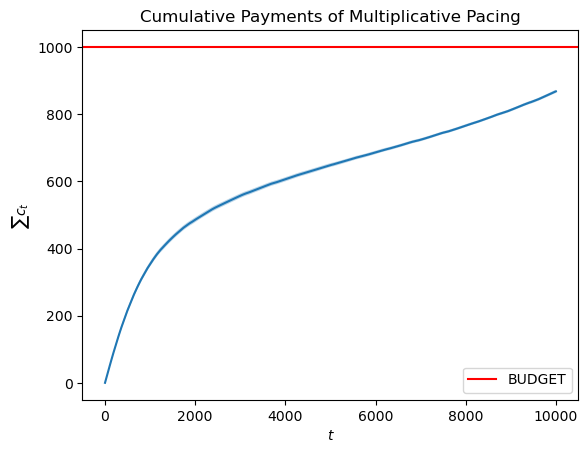

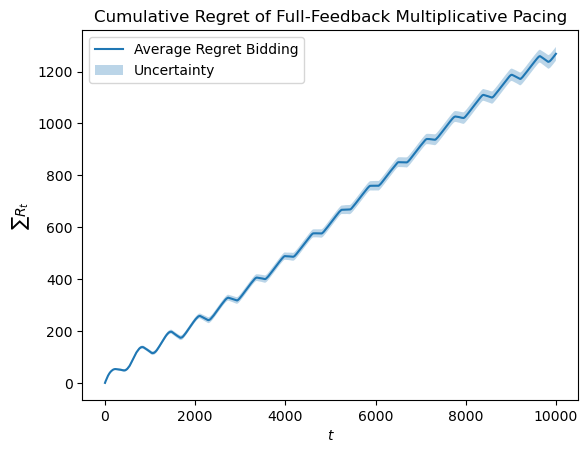

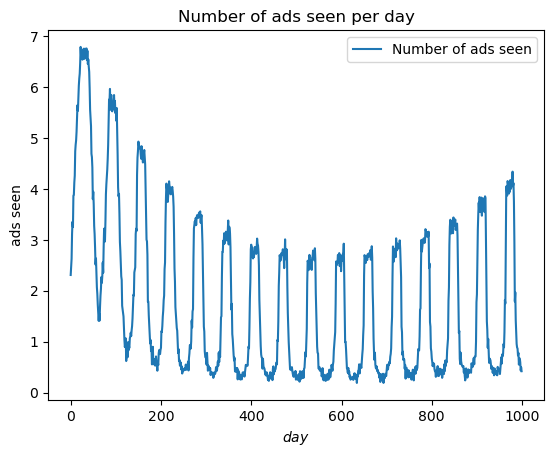

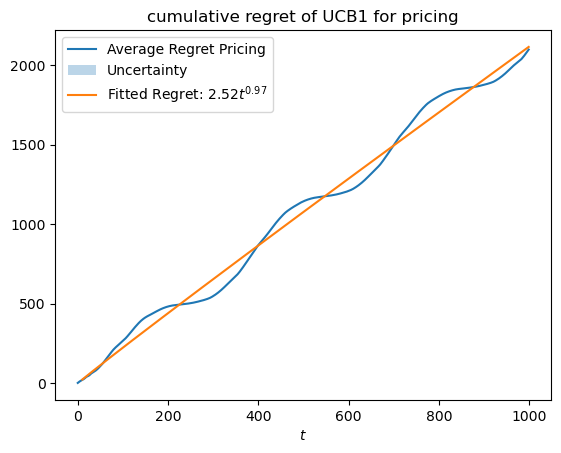

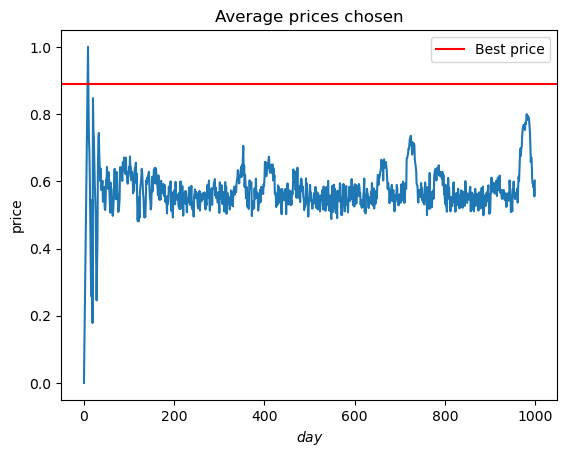

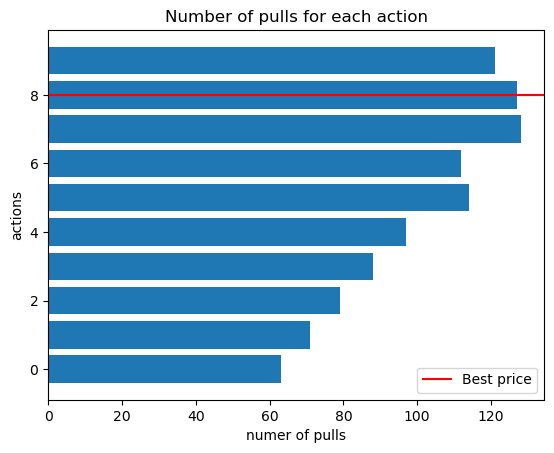

In [26]:
n_trials = ITERATIONS

regret_per_trial_pricing = []

regret_per_trial_bidding = []
all_payments = []
chosen_prices = []
seen_ads = []

eta = 1/np.sqrt(total_auctions)  # Learning rate from theory
q_a = np.random.rand(N_ADVERTISERS+1, NUMBER_OF_SLOTS)  # 11 rows (10 advertisers + me), 3 coloumns
ctrs = LAMBDAS*q_a
avg_ctrs = np.mean(ctrs, axis=1) # we compute the average among slots for each advertiser so we can pass this during the auction creation, otherwise it would be a mess to sort it and find the winners


for seed in range(n_trials):
    np.random.seed(seed)
    pricing_env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent(K=NUMBER_OF_PRICES, T=days, range=maximum_profit/2)

    auction = FirstPriceAuction(avg_ctrs, lambdas=LAMBDAS)
    bidding_agent = FFMultiplicativePacingAgent(bids_set=PRICES,
                                                                valuation=my_valuation,
                                                                budget=budget,
                                                                T=total_auctions,
                                                                eta=eta,
                                                                lambdas=LAMBDAS)

    pricing_agent_rewards = np.array([])
    pricing_agent_chosen_prices = np.zeros(days)

    bidding_utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])
    seen_ads_trial = np.zeros(days) # Number of users that have seen an ad

    for d in range(days):
        # Auction interaction
        for a in range(d*auctions_per_day, (d+1)*auctions_per_day):
            my_win = 0
            rank = 0
            # Agent places a bid
            my_bid = bidding_agent.bid()

            # Gather all bids for this auction
            bids = np.append(my_bid, other_bids[:, a].ravel())

            # Determine winners and payments
            winners, payments_per_click = auction.get_winners(bids=bids)

            # Check if the agent won
            #WE ADDED THIS FOR CICLE TO CHECK IF I WON AT LEAST ONE SLOT
            my_win = 0
            for i in range(len(winners)):
                if winners[i]==0:
                    my_win = 1
                    rank = i # THIS IS TO CHEK LATER THE UTILITY CONSIDERING THE VALUATION OF THE SLOT I WON
                    break

            # Calculate the utility and payment for the agent
            f_t = (my_valuation*LAMBDAS[rank] - my_bid) if my_win else 0
            c_t = my_bid*my_win

            # Update the agent's learning based on the auction outcome
            bidding_agent.update(f_t, c_t, other_bids_sorted[:, a])

            # Update the total number of users that have seen an ad
            seen_ads_trial[d] += my_win*np.random.binomial(1, LAMBDAS[rank])

            # Store the results
            bidding_utilities = np.append(bidding_utilities, f_t)  # Append utility
            my_bids = np.append(my_bids, my_bid)  # Append bid
            my_payments = np.append(my_payments, c_t)  # Append payment
            total_wins += my_win  # Increment total wins

            cumulative_payments = np.cumsum(my_payments)

        # Pricing interaction    
        pi_d = ucb_agent.pull_arm() ## the agent returns the index!!
        p_d = prices[pi_d] # I get the actual price
        pricing_agent_chosen_prices[d] = p_d
        d_d, r_d = pricing_env.round(p_d, seen_ads_trial[d], d)
        ucb_agent.update(r_d)

        pricing_agent_rewards = np.append(pricing_agent_rewards, r_d)

    regret_per_trial_bidding.append(np.cumsum(expected_clairvoyant_utilities_multiple_slots-bidding_utilities))
    all_payments.append(cumulative_payments)

    cumulative_regret_pricing = np.cumsum(expected_clairvoyant_rewards-pricing_agent_rewards)
    regret_per_trial_pricing.append(cumulative_regret_pricing)

    seen_ads.append(seen_ads_trial)

    chosen_prices.append(pricing_agent_chosen_prices)

avg_regret_bidding = np.array(regret_per_trial_bidding).mean(axis=0)
std_regret_bidding = np.array(regret_per_trial_bidding).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_ads_seen = np.array(seen_ads).mean(axis=0)

avg_prices = np.array(chosen_prices).mean(axis=0)

# bidding plots
plt.plot(np.arange(total_auctions), avg_payments)
plt.fill_between(np.arange(total_auctions), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(budget, color='red', label='BUDGET')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

plt.plot(np.arange(total_auctions), avg_regret_bidding, label='Average Regret Bidding')
plt.fill_between(np.arange(total_auctions), avg_regret_bidding-std_regret_bidding, avg_regret_bidding+std_regret_bidding, alpha=0.3, label='Uncertainty')
"""def model(x, a, b):
    return a*(x**b*(np.log(x)))
fit_window = np.arange(10, total_auctions)
popt, pcov = curve_fit(model, fit_window, avg_regret_bidding[fit_window])
ymodel = model(fit_window, *popt)
plt.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))"""
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.legend()
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()

# plot the number of ads seen per day
plt.plot(np.arange(days), avg_ads_seen, label='Number of ads seen')
plt.title('Number of ads seen per day')
plt.xlabel('$day$')
plt.ylabel('ads seen')
plt.legend()
plt.show()

# pricing plots
regret_per_trial_pricing = np.array(regret_per_trial_pricing)

average_regret_pricing = regret_per_trial_pricing.mean(axis=0)
regret_sd_pricing = regret_per_trial_pricing.std(axis=0)

plt.plot(np.arange(days), average_regret_pricing, label='Average Regret Pricing')
plt.title('cumulative regret of UCB1 for pricing')
plt.fill_between(np.arange(days),
                average_regret_pricing-regret_sd_pricing/np.sqrt(n_trials),
                average_regret_pricing+regret_sd_pricing/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
def model(x, a, b):
    return a*(x**b)
fit_window = np.arange(10, days)
popt, pcov = curve_fit(model, fit_window, average_regret_pricing[fit_window])
ymodel = model(fit_window, *popt)
plt.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}$' % (popt[0], popt[1]))
plt.xlabel('$t$')
plt.legend()
plt.show()


plt.figure()
plt.plot(np.arange(days), avg_prices)
plt.axhline(prices[best_price_index], color='red', label='Best price')
plt.title('Average prices chosen')
plt.xlabel('$day$')
plt.ylabel('price')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(NUMBER_OF_PRICES), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();